In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
from datetime import datetime, timedelta
import io
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
%matplotlib inline

def get_df(date):
    base = date - timedelta(days=1)
    d = base.strftime("%m-%d-%Y")
    url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{}.csv"
    s = requests.get(url.format(d)).content
    return (base, pd.read_csv(io.StringIO(s.decode('utf-8'))))

def get_counts(df):
    key_state, key_us = "Province_State", "Country_Region"
    if key_state in df.columns:
        key_state, key_us = key_state, key_us
    else:
        key_state, key_us = key_state.replace("_", "/"), key_us.replace("_", "/")
        
    ca_mask, ny_mask, us_mask = df[key_state] == STATE1, df[key_state] == STATE2, df[key_us] == "US"
    return [df[ca_mask]["Confirmed"].sum(), df[ny_mask]["Confirmed"].sum(), df[us_mask]["Confirmed"].sum()]

def get_perc(c):
    # ca1, ny1, us1, ca2, ny2, us2 = c
    percentages = [(c[3] - c[0]) / c[0], (c[4] - c[1]) / c[1], (c[5] - c[2]) / c[2]]
    return [round(100 * x, 2) for x in percentages]

def get_df_list(month, day, past):
    date_list = [datetime(2020, month, day) - timedelta(days=x) for x in range(past)]
    return [get_df(date) for date in date_list]

def get_data(df_list):
    date_counts, date_percs = [], []
    for date, df in df_list:
        c = get_counts(df)
        date_counts.append((date, [c[0], c[1], c[2]]))
    for i in range(len(date_counts) - 1, 0, -1):
        perc = get_perc(date_counts[i][1] + date_counts[i - 1][1])
        date_percs.append((date_counts[i-1][0], perc))
    state1 = [p[1][0] for p in date_percs], [c[1][0] for c in date_counts[1:]]
    state2 = [p[1][1] for p in date_percs], [c[1][1] for c in date_counts[1:]]
    us = [p[1][2] for p in date_percs], [c[1][2] for c in date_counts[1:]]
    return state1, state2, us

def perc_count_pairs(time_data, y_data):
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,8))
    zipped = [[(ax1, p), (ax2, c)] for (p, c) in y_data]
    for (ax1, y1), (ax2, y2) in zipped:
        delta = timedelta(days=1)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))        
        ax1.set_xlim([min(time_data) - delta, max(time_data) + delta])
        ax1.plot_date(time_data, y1);
        ax1.set_ylabel(f"Daily % Increase")
        ax2.set_ylabel(f"Number of Cases")
        ax2.plot_date(time_data, y2);
        legend = (f"{STATE1}", f"{STATE2}", "US")
        ax1.legend(legend)
        ax2.legend(legend)

In [7]:
# gis_data = df_list.copy()
gis_data = get_df_list(4, 5, 21)
time_data = [date for date, _ in gis_data[0:-1:]]

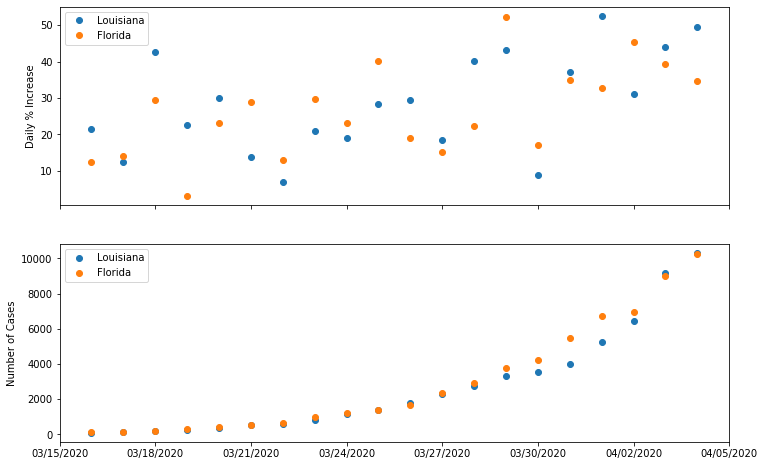

In [9]:
STATE1 = "Louisiana"
STATE2 = "Florida"
y_data = get_data(gis_data)
perc_count_pairs(time_data, y_data[:-1])

In [20]:
def get_all_states(df):
    all_states = list(set(df[df["Country_Region"] == "US"]["Province_State"]))
    all_states.remove("Diamond Princess")
    all_states.remove("Grand Princess")
    all_states.remove("Guam")
    all_states.remove("Northern Mariana Islands")
    all_states.remove("Recovered")
    all_states.remove("Virgin Islands")
    all_states.remove("Puerto Rico")
    all_states.remove("District of Columbia")
    df_pop = pd.read_csv("data/nst-est2019-alldata.csv")
    df_pop = df_pop[df_pop.NAME.isin(all_states)]
    state_pop = dict(df_pop[["NAME", "POPESTIMATE2018"]].values)
    return all_states, state_pop

def group_per_df(gis_data):
    grouped_state_df_list = []
    for date, df in gis_data:
        if key1 in df.columns:
            key = key1
        else:
            key = key2
        state_df = df[df[key].isin(all_states)]
        grouped_state_df = state_df[[key, "Confirmed"]].groupby(key).sum().reset_index()
        grouped_state_df["population"] = [state_pop[x] for x in grouped_state_df[key]]
        grouped_state_df["percentage"] = round(1000000 * grouped_state_df["Confirmed"] / grouped_state_df["population"], 3)
        grouped_state_df["1_in_x"] = round(grouped_state_df["population"] / grouped_state_df["Confirmed"])
        grouped_state_df.sort_values(by="percentage", ascending=False, inplace=True)
        grouped_state_df_list.append((date, grouped_state_df))
    return grouped_state_df_list

In [24]:
def get_csv(grouped_state_df_list, all_states, metric="percentage"):
    N = len(grouped_state_df_list)
    all_dates = [grouped_state_df_list[i][0].strftime("%B %d") for i in range(N)]
    count_dict = [{"state": None, "url": None} for i in range(N)]
    [count_dict[i].update({date: None for date in all_dates}) for i in range(N)]
    state_dict = {s: {"state": s} for s in all_states}
    [d.update({date: 0 for date in all_dates[::-1]}) for d in state_dict.values()]

    for i in range(N):
        date_string = grouped_state_df_list[i][0].strftime("%B %d")
        key = key1 if (key1 in grouped_state_df_list[i][1].columns) else key2
        df_temp = grouped_state_df_list[i][1][[key, metric]]
        data_list = df_temp.values.tolist()
        for state, count in data_list:
            state_dict[state][date_string] = count
    return state_dict

key1, key2 = "Province_State", "Province/State"
all_states, state_pop = get_all_states(gis_data[0][1])
grouped_state_df_list = group_per_df(gis_data)
perc_dict = get_csv(grouped_state_df_list, all_states, "percentage")
my_df = pd.DataFrame(perc_dict.values())
base_flag_url = 'https://raw.githubusercontent.com/CivilServiceUSA/us-states/master/images/flags/{state_name}-large.png'
my_df['url'] = [base_flag_url.format(state_name=state.replace(" ", "-").lower()) for state in all_states]
my_df.to_csv(r'rate_data.csv', index=False)

In [26]:
count_dict = get_csv(grouped_state_df_list, all_states, "Confirmed")
base_flag_url = 'https://raw.githubusercontent.com/CivilServiceUSA/us-states/master/images/flags/{state_name}-large.png'
my_df = pd.DataFrame(count_dict.values())
my_df['url'] = [base_flag_url.format(state_name=state.replace(" ", "-").lower()) for state in all_states]
my_df.to_csv(r'count_data.csv', index=False)